In [2]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from baselines.run_rl.baselines_util import play_baselines
import numpy as np
from numpy import pi
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline


import sys
sys.path.append('/home/sgillen/work/research/')

from utils.nn_utils import fit_model
import torch
from tqdm import trange
import tqdm

import torch.nn as nn
torch.set_default_dtype(torch.float32)

Logging to /tmp/openai-2019-07-16-22-31-54-716864


In [6]:
save_path = './data/car/signed_car8'
model, env = play_baselines(save_path) # This is loading the trained model for analysis
myenv = env.envs[0].env.env # OpenAI uses a bunch of wrappers around my env that don't maintain the member variables I put it


./data/car/signed_car8
signed_car8
Logging to /tmp/openai-2019-07-16-22-33-40-383799
env_type: bullet
init
options= 
Training ppo2 on bullet:bullet_car-v0 with arguments 
{'nsteps': 2048, 'nminibatches': 32, 'lam': 0.95, 'gamma': 0.99, 'noptepochs': 10, 'log_interval': 1, 'ent_coef': 0.0, 'lr': <function bullet.<locals>.<lambda> at 0x7f704e5c70d0>, 'cliprange': 0.2, 'value_network': 'copy', 'num_layers': 3, 'num_hidden': 24, 'load_path': '/home/sgillen/work/baselines/baselines/run_rl/data/car/signed_car8/saved_model', 'network': 'mlp'}


ValueError: Variable ppo2_model/pi/mlp_fc0/w/Adam/ already exists, disallowed. Did you mean to set reuse=True or reuse=tf.AUTO_REUSE in VarScope? Originally defined at:

  File "/home/sgillen/work/baselines/baselines/ppo2/model.py", line 111, in __init__
    self._train_op = self.trainer.apply_gradients(grads_and_var)
  File "/home/sgillen/work/baselines/baselines/ppo2/ppo2.py", line 108, in learn
    max_grad_norm=max_grad_norm)
  File "/home/sgillen/work/baselines/baselines/run.py", line 83, in train
    **alg_kwargs


In [ ]:
# Generate data for the supervised learning task

myenv = env.envs[0].env.env # OpenAI uses a bunch of wrappers around my env that don't maintain the member variables I put it
myenv.num_steps=50

num_episodes = 20000
t_min = 50; t_max=myenv.num_steps; num_t = 1;
t_vals = np.linspace(t_min, t_max, num_t, dtype=np.int)

init_states = torch.zeros(t_vals.size, num_episodes, myenv.observation_space.shape[0]+1)  
final_states = torch.zeros(t_vals.size, num_episodes)

dt = myenv._timeStep
total_time = dt * myenv.num_steps  

init_states = []
final_states = []

ep = 0
for ep in trange(num_episodes):
        
        # init histories for this episode
        ep_action_hist = np.zeros((myenv.num_steps, myenv.action_space.shape[0]))
        ep_state_hist = np.zeros((myenv.num_steps, myenv.observation_space.shape[0]))
        ep_reward_hist = np.zeros((myenv.num_steps, 1))

        obs = env.reset()

        # set the goal for this iteratiom
        r_goal = np.random.uniform(low = .1, high = 5)
        th_goal = np.random.uniform(low=-pi, high = pi)
    
        x_goal = r_goal*np.cos(th_goal)
        y_goal = r_goal*np.sin(th_goal)
        
        myenv.goal = [x_goal,y_goal,.1]
     
        obs, _,_,_ = myenv.step(np.zeros(myenv.action_space.shape))
        init_states.append(torch.tensor(obs,dtype=torch.float32))

        for i in range(myenv.num_steps):
            actions, value, _, log_prob = model.step(obs)
            obs, reward, done, _ = env.step(actions)  


            ep_action_hist[i,:] = np.copy(actions)
            ep_state_hist[i,:] = np.copy(obs)
            ep_reward_hist[i,:] = np.copy(reward)
            if done:
                break

      
        t_rem = myenv.num_steps*dt
        final_states.append(ep_state_hist[-1,:])          
                

In [ ]:
import pickle
with open("init_states_20000r", "wb") as init_state_file:
    pickle.dump(init_states,init_state_file)
    
with open("final_states_20000r", "wb") as final_state_file:
    pickle.dump(final_states,final_state_file)

In [1]:
import pickle

init_states = pickle.load(open("init_states_20000r", "rb" ))
final_states = pickle.load(open("final_states_20000r", "rb"))

100%|██████████| 50/50 [00:27<00:00,  1.79it/s]

CPU times: user 5min 42s, sys: 1.13 s, total: 5min 43s
Wall time: 27.5 s


<Figure size 432x288 with 0 Axes>

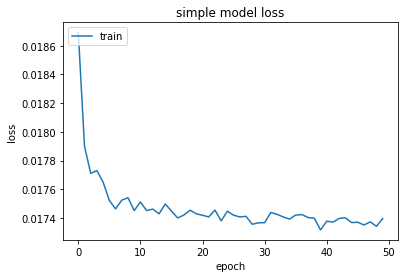

<Figure size 432x288 with 0 Axes>

In [9]:
# Do the supervised learning with MLP

# Define and train the feedforward network
es_model = nn.Sequential(
    nn.Linear(7,28),
    nn.ReLU(),
    nn.Linear(28,28),
    nn.ReLU(),
    nn.Linear(28,28),
    nn.ReLU(),
    nn.Linear(28,7),
)

# reshape variables for the training 
state_train = torch.cat(init_states).reshape(-1,myenv.observation_space.shape[0])

state_min = torch.min(state_train, dim=0)[0]
state_max = torch.max(state_train, dim=0)[0]

# normalize the state training inpit
#state_train_normal = ((state_train - state_min)/state_max)
state_train_normal = state_train



final_state_train = torch.tensor(final_states, dtype=torch.float32)

#final_state_train = final_states.reshape(-1,myenv.observation_space.shape[0])
#final_state_train = final_states.reshape(-1,1)

%time loss_hist = fit_model(es_model, state_train_normal, final_state_train, num_epochs=50, learning_rate=1e-2, loss_fn=torch.nn.MSELoss(), shuffle=True)

plt.plot(loss_hist)
plt.title('simple model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.figure()

In [10]:
# Analyze the agility of our policy network with a grid search
# Also makes predictions for agility based on the predictor above

r_min = .1;
r_max = 7;
num_r = 10
r_vals = np.linspace(r_min, r_max, num_r)

th_min = -pi;
th_max = pi;
num_th = 30
th_vals = np.linspace(th_min, th_max, num_th)

t_min = 50;
t_max = 50;
num_t = 1;
t_vals = np.linspace(t_min, t_max, num_t, dtype=np.int)

myenv = env.envs[
    0].env.env  # OpenAI uses a bunch of wrappers around my env that don't maintain the member variables I put it
myenv.num_steps = 50


fs_eval = np.zeros((r_vals.size, th_vals.size, t_vals.size, myenv.observation_space.shape[0]))
fs_pred = np.zeros((r_vals.size, th_vals.size, t_vals.size, myenv.observation_space.shape[0]))

for ri, r in enumerate(tqdm.tqdm(r_vals)):
    for thi, th in enumerate(th_vals):

        action_hist = np.zeros((myenv.num_steps, myenv.action_space.shape[0]))
        state_hist = np.zeros((myenv.num_steps, myenv.observation_space.shape[0]))
        reward_hist = np.zeros((myenv.num_steps, 1))

        obs = env.reset()

        x_goal = r * np.cos(th)
        y_goal = r * np.sin(th)

        myenv.goal = [x_goal, y_goal, .1]
        # myenv.goal = [1.8209177347168357, -1.6828028606611047, 0.1]
        # myenv.goal  = [1.8373192126473523, -0.9243333822434766, 0.1]

        obs, _, _, _ = myenv.step(np.zeros(myenv.action_space.shape))

        for it, t in enumerate(t_vals):
            net_input = torch.tensor(obs.squeeze(), dtype=torch.float32)
            clf_input = obs.squeeze().reshape(1, -1)

            # net_input = torch.cat((torch.tensor(obs.squeeze()[0:2]), torch.tensor(t*dt,dtype=torch.float32).view(1)))
            # net_input = (net_input - state_min)/state_max
            fs_pred[ri, thi, it] = es_model(net_input).detach()

           
        actions, _, _, _, = model.step(obs)

        num_trials = 1
        for trial in range(num_trials):
            for i in range(myenv.num_steps):
                actions, value, _, log_prob = model.step(obs)
                obs, reward, done, _ = env.step(actions)
                action_hist[i, :] = np.copy(actions)
                state_hist[i, :] = np.copy(obs)
                reward_hist[i, :] = np.copy(reward)

                # env.render()
                if done:
                    break

        
        fs_eval[ri, thi, it] = state_hist[-1,:]

                    # eps_end = np.max(np.nonzero(state_hist[:,1]))  

100%|██████████| 10/10 [01:15<00:00,  7.26s/it]


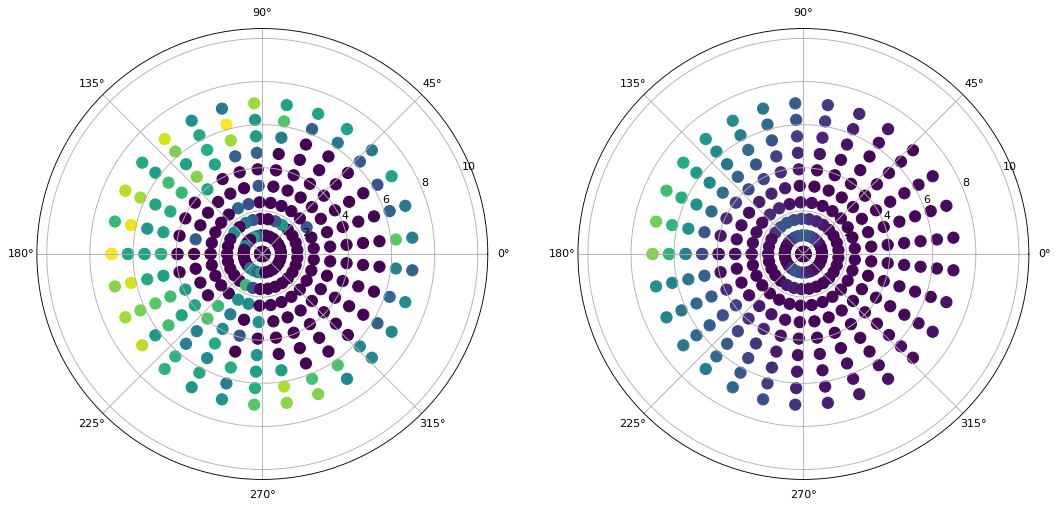

In [11]:
# Print real agility map
colors_eval = []; colors_pred = []; th_plt_vals = []; r_plt_vals = [];

for i,ival in enumerate(fs_eval[:,:,:]):
    for j,val in enumerate(ival):
        th_plt_vals.append(th_vals[j])
        r_plt_vals.append(r_vals[i])
        colors_eval.append(np.sqrt(np.sum(val**2)))
        
for i,ival in enumerate(fs_pred[:,:,:]):
    for j,val in enumerate(ival):
        colors_pred.append(np.sqrt(np.sum(val**2)))

        
fig= plt.figure(figsize=(16, 16), dpi= 80, facecolor='w', edgecolor='k')

max_color = max(np.max(colors_eval), np.max(colors_pred))
colors_predn = colors_pred/max_color
colors_evaln = colors_eval/max_color


ax = fig.add_subplot(121, projection='polar')
c = ax.scatter(np.reshape(th_plt_vals,-1),np.reshape(r_plt_vals,-1), c=np.reshape(colors_evaln,-1), s=100, vmin=0, vmax=1)

ax = fig.add_subplot(122, projection='polar')
c = ax.scatter(np.reshape(th_plt_vals,-1),np.reshape(r_plt_vals,-1), c=np.reshape(colors_predn,-1), s=100, vmin=0, vmax=1)

#fig.colorbar(cm.ScalarMappable(), ax=ax)

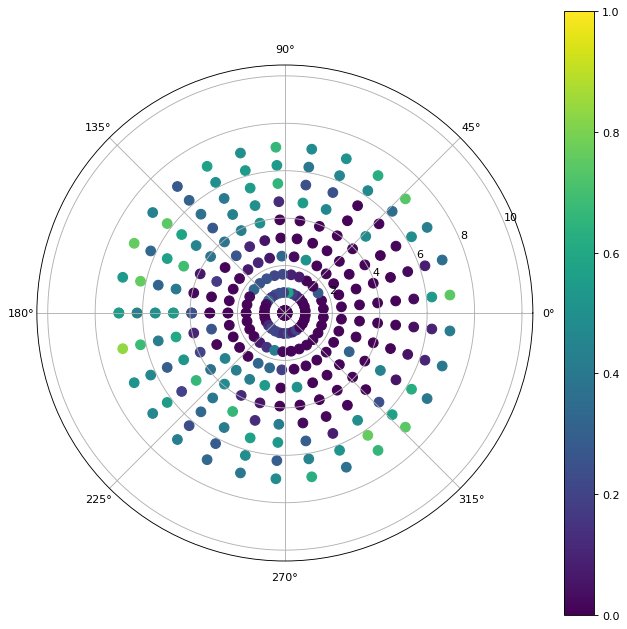

In [230]:
diff_colors = []; th_plt_vals = []; r_plt_vals = [];

fs_diff = fs_pred - fs_eval
for i,ival in enumerate(fs_diff):
    for j,val in enumerate(ival):
        th_plt_vals.append(th_vals[j])
        r_plt_vals.append(r_vals[i])
        diff_colors.append(np.sqrt(np.sum((val)**2)))

    

diff_colorsn = diff_colors/max_color
fig= plt.figure(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111, projection='polar')
c = ax.scatter(np.reshape(th_plt_vals,-1),np.reshape(r_plt_vals,-1), c=np.reshape(diff_colorsn,-1), s=75,vmin=0, vmax=1)
fig.colorbar(cm.ScalarMappable(), ax=ax)

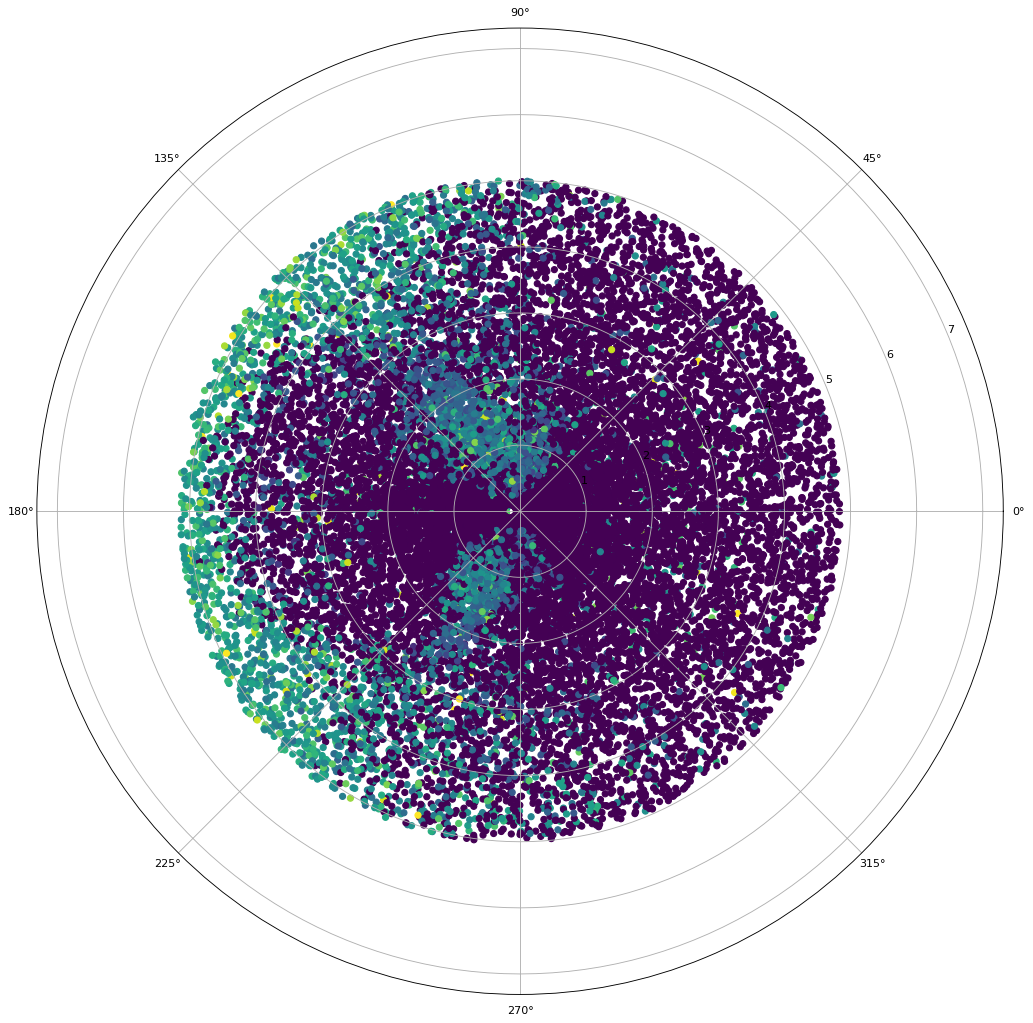

In [48]:
final_states_plot = np.array([state for state in final_states])
colors = np.array([np.sqrt(np.sum(state**2))/max_color for state in final_states_plot])

fig= plt.figure(figsize=(16, 16), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111, projection='polar')

c = ax.scatter(np.reshape(final_states_plot[:,1],-1),np.reshape(final_states_plot[:,0],-1), s=30,c = np.reshape(colors,-1), vmin=0, vmax=1)
c = ax.scatter(np.reshape(init_states_plot[:,1],-1),np.reshape(init_states_plot[:,0],-1), s=30,c = np.reshape(colors,-1), vmin=0, vmax=1)

